In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.stats import gaussian_kde
from sklearn.metrics import explained_variance_score
from matplotlib import pyplot as plt
%matplotlib inline

In [107]:
# Data class contains the data and extracts all the details.
class Data():
    def __init__(self, input_file, batch_size):
        # type: (object, object) -> object
        # type: (object, object) -> object
        """
        :param input_file: path to the input_file
        :param batch_size: size of the batches to use with this data
        """
        data = pd.read_table(input_file)
        data.aaMutations = data.mut_list.fillna('')
        unique_mutations = set(':'.join(data.aaMutations).split(':'))
        unique_mutations = sorted(list(unique_mutations))
#         unique_mutations.remove('')

        self.data = data
        self.unique_mutations = unique_mutations
        self.batch_size = batch_size
        self.input_file = input_file

        self.nn_genotypes_values, self.nn_brightness_values = format_data(self)

        self.nn_genotypes_test, self.nn_brightness_test, self.nn_genotypes_train, self.nn_brightness_train = \
            split(self)

        self.batch_number = int(len(self.nn_brightness_train) / self.batch_size)
        self.batches, self.test_batches, self.to_plot_observed, self.to_plot_observed_test = get_batches(self)

        self.nn_genotypes = tf.placeholder(tf.float32, shape=[self.batch_size, 1, len(unique_mutations)])
        self.nn_brightness = tf.placeholder(tf.float32, shape=[self.batch_size, 1, 1])

    def reshuffle(self):
        # self.nn_genotypes_test, self.nn_brightness_test, self.nn_genotypes_train, self.nn_brightness_train = \
        #     split(self)
        self.batches, self.test_batches, self.to_plot_observed, self.to_plot_observed_test = get_batches(self)

In [96]:
# Format data, split into feature matrix and target value vector
def format_data(data):
    # shuffling rows in the data df
    unique_mutations = data.unique_mutations
    data = data.data.reindex(np.random.permutation(data.data.index))

    # formatting data for the nn input
    print('Normalizing data...')
    nn_genotypes_values = np.zeros((len(data), len(unique_mutations)))
    nn_brightness_values = data.fitness.values
    for i in range(len(unique_mutations)):
        nn_genotypes_values[:, i] = data.mut_list.str.contains(unique_mutations[i]).astype(np.float32)

    nn_brightness_values = (nn_brightness_values - min(nn_brightness_values)) / max(
        nn_brightness_values - min(nn_brightness_values)) * 2 - 1

    return nn_genotypes_values, nn_brightness_values

In [97]:
# Split data into test and train sets randomly
def split(data):
    length = len(data.data)
    test_id = np.random.randint(0, length, data.batch_size)
    train_id = np.array([x for x in np.arange(length) if x not in test_id])

    genotypes_test, genotypes_train = data.nn_genotypes_values[test_id], data.nn_genotypes_values[train_id]
    brightness_test, brightness_train = data.nn_brightness_values[test_id], data.nn_brightness_values[train_id]

    return genotypes_test, brightness_test, genotypes_train, brightness_train

In [98]:
# Shuffle train set, split train set into batches. Get train batches and test batches
def get_batches(data):
    length = len(data.nn_brightness_train)
    batches = []
    test_batches = []
    ids = np.array([x for x in np.arange(length)])
    to_plot_observed = []

    for i in range(data.batch_number):
        current_ids = np.random.choice(ids, data.batch_size, replace=False)
        ids = np.array([x for x in ids if x not in current_ids])

        current_batch = data.nn_genotypes_train[current_ids].reshape(data.batch_size, 1, len(data.unique_mutations))
        current_batch_brightness = data.nn_brightness_train[current_ids].reshape(data.batch_size, 1, 1)
        to_plot_observed.append(data.nn_brightness_train[current_ids])
        batches.append((current_batch, current_batch_brightness))

    test_batch = data.nn_genotypes_test.reshape(data.batch_size, 1, len(data.unique_mutations))
    test_batch_brightness = data.nn_brightness_test.reshape(data.batch_size, 1, 1)
    test_batches.append((test_batch, test_batch_brightness))
    to_plot_observed_test = data.nn_brightness_test.reshape(data.batch_size)
    to_plot_observed = np.array(to_plot_observed).reshape(data.batch_number * data.batch_size)

    return batches, test_batches, to_plot_observed, to_plot_observed_test

In [99]:
# Broadcast a tensor (used before multiplication with weights)
def broadcast(tensor, batch_size):
    return tf.tile(tensor, (batch_size, 1, 1))

In [115]:
# Plot the observed values versus predicted using density plot
def density_plot(x, y, iteration_number, costs, test_score):
    ''' x = observed, y = predicted '''
    x = x[(~np.isnan(x)) & (~np.isnan(y))]
    y = y[(~np.isnan(x)) & (~np.isnan(y))]

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # formatting
    plt.figure(figsize=[6, 4])
    plt.scatter(x, y, c=z, s=3, edgecolor='', cmap='viridis_r')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('Observed brightness')
    plt.ylabel('Predicted brightness')
    plt.title('Iteration %s: cost=%.7f, EVS=%.2f' % (iteration_number, costs, test_score))
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                    labelbottom="on", left="off", right="off", labelleft="on")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_color('gray')
    plt.gca().spines["left"].set_color('gray')
    plt.gca().xaxis.grid(True)
    plt.gca().yaxis.grid(True)

In [101]:
input_file = '/Users/katya/Lab/CRG/Research/HIS3InterspeciesEpistasis/Analysis/Katya/NN/S1_short.txt'
batch_size = 100

In [102]:
# Neural network class. Extracts neural net structure from the parameter file.
# Contains all the details of the neural network to be used.
class TFNet(object):
    def __init__(self, net_structure, input_data, optimizer_method, learning_rate, batch_size):
        '''
            :param net_structure:
                                {'layer1':(3, tf.tanh()),
                                'layer2':((3, tf.tanh()),
                                'layer3':(1, tf.tanh())}

            :return:

            https://www.tensorflow.org/versions/r0.9/api_docs/python/nn.html#activation-functions

            '''

        self.number_of_layers = len(net_structure)
        self.structure = net_structure

        self.neurons = {}
        self.weights = {}
        self.biases = {}
        self.input = {}
        self.output = {}

        for i in range(self.number_of_layers):
            layer = 'layer' + str(i + 1)
            self.neurons[layer] = int(self.structure[layer][0])
            self.weights[layer] = tf.Variable(
                tf.random_normal([1, len(input_data.unique_mutations), self.neurons[layer]]),
                name=layer + '_weights')
            self.biases[layer] = tf.Variable(tf.random_normal([1, 1, self.neurons[layer]]), name=layer + '_biases')
            self.input[layer] = tf.add(
                tf.matmul(input_data.nn_genotypes, broadcast(self.weights[layer], batch_size)),
                broadcast(self.biases[layer], batch_size))
            self.output[layer] = eval(self.structure[layer][1])(self.input[layer])

        weights = [(self.weights[x]) for x in ['layer1', 'layer2', 'layer3']]
        regularizer = tf.contrib.layers.l2_regularizer(0.001)

        self.cost = tf.reduce_sum(tf.pow(self.output[layer] - input_data.nn_brightness, 2)) / batch_size
        self.cost = tf.reduce_mean(self.cost + tf.contrib.layers.apply_regularization(regularizer, weights))
        self.optimizer = eval(optimizer_method)(learning_rate).minimize(self.cost)

        self.init = tf.global_variables_initializer()
        self.saver = tf.train.Saver()

    def __str__(self):
        print('Net structure:\n')
        for i in range(self.number_of_layers):
            print('%s neurons in layer_' % (self.neurons['layer' + str(i + 1)]) + str(i + 1) + '\n')

In [103]:
learning_rate = 0.1

optimizer_method = 'tf.train.AdagradOptimizer'
line = 'net_structure\t1,tf.tanh\t3,tf.tanh\t1,tf.tanh'
net_structure = {}
counter = 1
for i in line.split('\t')[1:]:
    net_structure['layer' + str(counter)] = i.split(',')
    counter += 1
    
max_epochs = 200
reshuffling_frequency = 100

In [108]:
data = Data(input_file, batch_size)
net = TFNet(net_structure, data, optimizer_method, learning_rate, batch_size)

Normalizing data...


In [110]:
with tf.Session() as sess:
    
    # Initializing variables
    sess.run(net.init)

    # Initiating the session run for a specified number of iterations.
    for e in range(max_epochs):
        for batch, batch_brightness in data.batches:
            sess.run(net.optimizer, feed_dict={data.nn_genotypes: batch, data.nn_brightness: batch_brightness})
            
    # Write down the outputs every 10th iteration.
        if e % 10 == 0:

            # Extracting net cost function output.
            to_plot_predicted = np.zeros(data.batch_number * batch_size)
        
        
            for index, (batch, batch_brightness) in enumerate(data.batches):
                cost_value, l3_value = sess.run([net.cost, net.output['layer3']],
                                                feed_dict={data.nn_genotypes: batch,
                                                           data.nn_brightness: batch_brightness})

                to_plot_predicted[(index * batch_size):((index + 1) * batch_size)] = l3_value.reshape(batch_size)

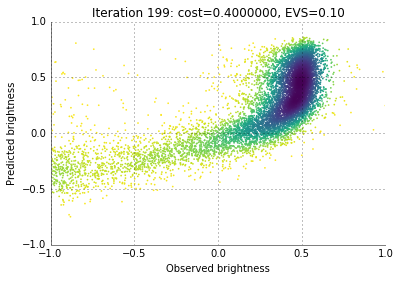

In [117]:
density_plot(np.array(data.to_plot_observed).reshape(9800), to_plot_predicted, e, 0.4, 0.1)